In [41]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import pandas as pd
import glob
import cv2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn import cluster
import os
import torch.nn.functional as F
from copy import deepcopy
from tqdm import tqdm
import plotly.express as px

In [2]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv(\
    'P1_Facial_Keypoints/data/training_frames_keypoints.csv')

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6043, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6043 (delta 0), reused 3 (delta 0), pack-reused 6038
Receiving objects: 100% (6043/6043), 329.52 MiB | 36.06 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Updating files: 100% (5805/5805), done.


In [3]:
data

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457,Thomas_Ferguson_02.jpg,35.0,94.0,35.0,105.0,38.0,112.0,40.0,123.0,46.0,...,71.0,123.0,79.0,121.0,71.0,123.0,66.0,126.0,64.0,126.0
3458,Valerie_Harper_00.jpg,72.0,133.0,76.0,147.0,80.0,159.0,87.0,170.0,91.0,...,120.0,156.0,135.0,159.0,124.0,163.0,117.0,167.0,113.0,166.0
3459,Maggie_Smith_00.jpg,52.0,149.0,56.0,160.0,63.0,168.0,71.0,179.0,78.0,...,122.0,169.0,133.0,169.0,122.0,172.0,115.0,172.0,111.0,172.0
3460,Erin_Hershey_Presley_41.jpg,82.0,91.0,82.0,105.0,82.0,116.0,86.0,128.0,90.0,...,119.0,132.0,134.0,136.0,119.0,139.0,112.0,139.0,108.0,139.0


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
class FacesDataset(Dataset):
  def __init__(self, df):
    super(FacesDataset).__init__()
    self.df = df
    self.normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )

  def __len__(self):
    return len(self.df)

  def preprocess_input(self, img):
    img = cv2.resize(img, (224,224))
    img = torch.tensor(img).permute(2,0,1)
    img = self.normalize(img).float()
    return img.to(device)
  
  def __getitem__(self, idx):
    img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[idx,0]
    img = cv2.imread(img_path)/255
    kp = deepcopy(self.df.iloc[idx,1:].tolist()) # list of all the keypoints
    kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
    kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2) 
    img = self.preprocess_input(img)
    return img, kp2
  def load_img(self, ix):
    img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
    img = cv2.resize(img, (224,224))
    return img

In [9]:
def load_img(self, ix):
  img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
  img = cv2.resize(img, (224,224))
  return img

In [33]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FacesDataset(train.reset_index(drop=True))
test_dataset = FacesDataset(test.reset_index(drop=True))
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [19]:
def get_model():
  model = models.vgg16(weights="VGG16_Weights.DEFAULT")
  for params in model.parameters():
    params.requires_grad = False
  model.avgpool = nn.Sequential(
      nn.Conv2d(512,512,3),
      nn.MaxPool2d(2),
      nn.Flatten()
      )
  model.classifier = nn.Sequential(
      nn.Linear(2048, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 136),
      nn.Sigmoid()
      )
  loss_fn = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  return model.to(device), loss_fn, optimizer

In [20]:
def train_batch(img, kps, model, optimizer, loss_fn):
  model.train()
  optimizer.zero_grad()
  preds_kps = model(img.to(device))
  loss = loss_fn(preds_kps, kps.to(device))
  loss.backward()
  optimizer.step()
  return loss.item()

In [21]:
@torch.no_grad()
def validate_batch(img, kps, model, criterion):
  model.eval()
  _kps = model(img.to(device))
  loss = criterion(_kps, kps.to(device))
  return _kps, loss

In [27]:
model, loss_fn, optimizer = get_model()

In [29]:
train_loss, test_loss = [], []
n_epochs = 50

loop = tqdm(range(1,n_epochs+1), total=n_epochs)
for epoch in loop:
  epoch_train_loss, epoch_test_loss = 0, 0
  for ix, (img, kps) in enumerate(train_loader):
    loss = train_batch(img, kps, model, optimizer, loss_fn)
    epoch_train_loss += loss
  epoch_train_loss /= (ix+1)
  for ix,(img,kps) in enumerate(test_loader):
    ps, loss = validate_batch(img, kps, model, loss_fn)
    epoch_test_loss += loss.item() 
  epoch_test_loss /= (ix+1)
  train_loss.append(epoch_train_loss)
  test_loss.append(epoch_test_loss)
  loop.set_postfix_str(f"train_loss = {round(epoch_train_loss,3)} | val_loss = {round(epoch_test_loss,3)}")

100%|██████████| 50/50 [28:09<00:00, 33.80s/it, train_loss = 0.015 | val_loss = 0.018]


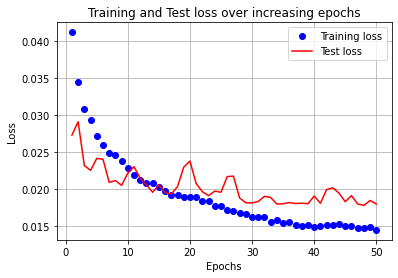

In [30]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

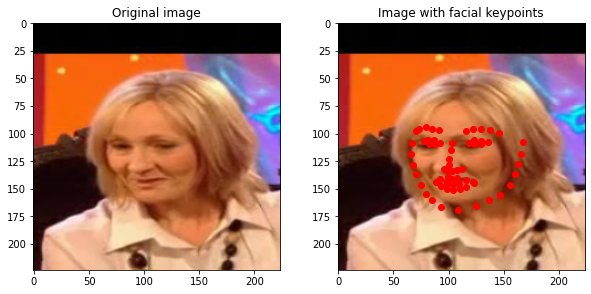

In [34]:
ix = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

In [35]:
!pip install -qU face-alignment
import face_alignment

  Preparing metadata (setup.py) ... done


In [36]:
!wget https://www.dropbox.com/s/2s7xjto7rb6q7dc/Hema.JPG

--2023-02-22 11:15:36--  https://www.dropbox.com/s/2s7xjto7rb6q7dc/Hema.JPG
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/2s7xjto7rb6q7dc/Hema.JPG [following]
--2023-02-22 11:15:36--  https://www.dropbox.com/s/raw/2s7xjto7rb6q7dc/Hema.JPG
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfb3b3e0c798398ed21a0c9c3ba.dl.dropboxusercontent.com/cd/0/inline/B28y3Yo5dX_xmpIJ3cjw5htUlA5xi6H1p4oHRud1_B0Sha5cz1Dp-jGaqhRakTvkp5uZpefnj8Usbd7TvPAqf70PoKSaBzgP-K_wVfU8EkRkl3FpJ4AWvuy3Y66Pz7MlkLIOgNiMeZyWuO9HFjZ4BssyQQ27zF2tGJR_91s7peSIIQ/file# [following]
--2023-02-22 11:15:36--  https://ucfb3b3e0c798398ed21a0c9c3ba.dl.dropboxusercontent.com/cd/0/inline/B28y3Yo5dX_xmpIJ3cjw5htUlA5xi6H1p4oHRud1_B0Sha5cz1Dp-jGaqhRakTvkp5uZpefnj8Usbd7TvPAqf70PoKSa

In [37]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

In [38]:
input = cv2.imread('Hema.JPG')
preds = fa.get_landmarks(input)[0]
print(preds.shape)

(68, 2)


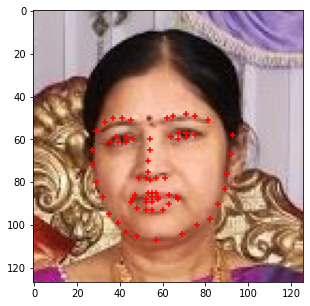

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(figsize=(5,5))
plt.imshow(cv2.cvtColor(cv2.imread('Hema.JPG'), \
                        cv2.COLOR_BGR2RGB))
ax.scatter(preds[:,0], preds[:,1], marker='+', c='r')
plt.show()

In [40]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, flip_input=False, device='cpu')
input = cv2.imread('Hema.JPG')
preds = fa.get_landmarks(input)[0]

df = pd.DataFrame(preds)
df.columns = ['x','y','z']

fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z')
fig.show()

Downloading: "https://www.adrianbulat.com/downloads/python-fan/3DFAN4-4a694010b9.zip" to /root/.cache/torch/hub/checkpoints/3DFAN4-4a694010b9.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/depth-6c4283c0e0.zip" to /root/.cache/torch/hub/checkpoints/depth-6c4283c0e0.zip


  0%|          | 0.00/224M [00:00<?, ?B/s]